## Load packages

In [1]:
from pathlib import Path

import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from lib.shared.file_utils import get_filename
from lib.aggregate.filter import load_parquet_subset
from lib.aggregate.cell_classification import CellClassifier
from lib.aggregate.montage_utils import create_cell_montage, add_filenames

## Load test data

In [2]:
CONFIG_FILE_PATH = "config/config.yml"
TEST_PLATE = 1
TEST_WELL = "A1"

In [3]:
# load config file and determine root path
with open(CONFIG_FILE_PATH, "r") as config_file:
    config = yaml.safe_load(config_file)
ROOT_FP = Path(config["all"]["root_fp"])

# Load subset of data
# Takes ~1 minute
merge_final_fp = (
    ROOT_FP
    / "merge"
    / "parquets"
    / get_filename({"plate": TEST_PLATE, "well": TEST_WELL}, "merge_final", "parquet")
)
cell_data = load_parquet_subset(merge_final_fp, n_rows=50000)
display(cell_data)

print("First 20 columns; use to set parameters below.")
for index, col in enumerate(cell_data.columns[:20]):
    print(index, col)

Reading first 50,000 rows from analysis_root/merge/parquets/P-1_W-A1__merge_final.parquet


,plate,well,tile,cell_0,i_0,j_0,site,cell_1,i_1,j_1,...,cell_number_neighbors_1,cell_percent_touching_1,cell_first_neighbor_distance,cell_second_neighbor_distance,cell_angle_between_neighbors,cytoplasm_number_neighbors_1,cytoplasm_percent_touching_1,cytoplasm_first_neighbor_distance,cytoplasm_second_neighbor_distance,cytoplasm_angle_between_neighbors
0,1,A1,1045,429,1478.403947,1481.714474,243,254,100.607843,670.117647,...,0,0.000000,48.501317,54.812638,164.492958,0.0,0.000000,48.482563,55.773102,160.427741
1,1,A1,401,485,1477.766431,1478.877654,101,294,100.089552,669.910448,...,1,0.049751,45.269871,62.882030,106.480590,1.0,0.028818,40.760186,57.586665,116.482954
2,1,A1,1502,501,1480.628283,1477.384343,354,277,100.674419,99.806202,...,0,0.000000,50.779623,74.421862,151.065981,0.0,0.000000,52.674577,70.256562,166.276907
3,1,A1,595,475,1480.676399,1482.874696,154,221,100.764706,670.764706,...,2,0.193548,36.794933,52.151249,171.453465,2.0,0.040404,39.327858,47.072292,154.575718
4,1,A1,1479,601,1477.695030,1481.850904,365,346,99.764045,671.494382,...,0,0.000000,57.697175,61.333366,138.748450,0.0,0.000000,62.644570,63.731803,133.933684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,1,A1,1125,453,1480.076923,1755.965545,278,220,100.432099,168.814815,...,1,0.027778,51.719049,57.920520,168.921134,1.0,0.015625,52.825726,62.730908,168.160355
49996,1,A1,1408,731,1753.173077,1440.839744,338,2338,739.098765,92.271605,...,0,0.000000,63.654194,75.970693,59.774914,0.0,0.000000,65.328179,79.941206,91.112332
49997,1,A1,525,334,1227.967429,1592.447678,120,1347,608.121212,697.919192,...,0,0.000000,52.176829,59.403882,169.852034,0.0,0.000000,49.825625,59.247234,172.702028
49998,1,A1,56,503,1600.628225,1728.227618,19,350,130.087379,160.582524,...,0,0.000000,60.944246,69.059469,44.366065,0.0,0.000000,62.061594,64.824308,55.486461


First 20 columns; use to set parameters below.
0 plate
1 well
2 tile
3 cell_0
4 i_0
5 j_0
6 site
7 cell_1
8 i_1
9 j_1
10 distance
11 fov_distance_0
12 fov_distance_1
13 sgRNA_0
14 gene_symbol_0
15 mapped_single_gene
16 channels_min
17 nucleus_DAPI_int
18 nucleus_COXIV_int
19 nucleus_CENPA_int


## See good mitotic cutoff with DAPI

In [4]:
def plot_mitotic_distribution_hist(
    threshold_variable_data, threshold_value, bins=100
):
    """Plot distribution of the threshold variable and calculate percent of mitotic cells.

    Args:
        cell_data (pd.DataFrame): Input dataframe containing cell measurements.
        threshold_variable (str): Column name for mitotic cell identification.
        threshold_value (float): Threshold value for separating mitotic cells.
        bins (int): Number of bins for histogram.

    Returns:
        float: Percentage of cells classified as mitotic.
    """
    # Create plot
    plt.figure(figsize=(10, 6))
    plt.hist(threshold_variable_data, bins=bins)
    plt.title(f"Histogram of threshold variable")
    plt.ylabel("Frequency")
    plt.axvline(
        x=threshold_value,
        color="r",
        linestyle="--",
        label=f"Mitotic threshold ({threshold_value})",
    )
    plt.legend()
    plt.show()

    # Calculate percent mitotic using the provided Series
    mitotic_mask = threshold_variable_data > threshold_value
    
    percent_mitotic = (mitotic_mask.sum() / len(cell_data)) * 100

    print(f"Number of mitotic cells: {mitotic_mask.sum():,}")
    print(f"Total cells: {len(cell_data):,}")
    print(f"Percent mitotic: {percent_mitotic:.2f}%")
    
    return percent_mitotic

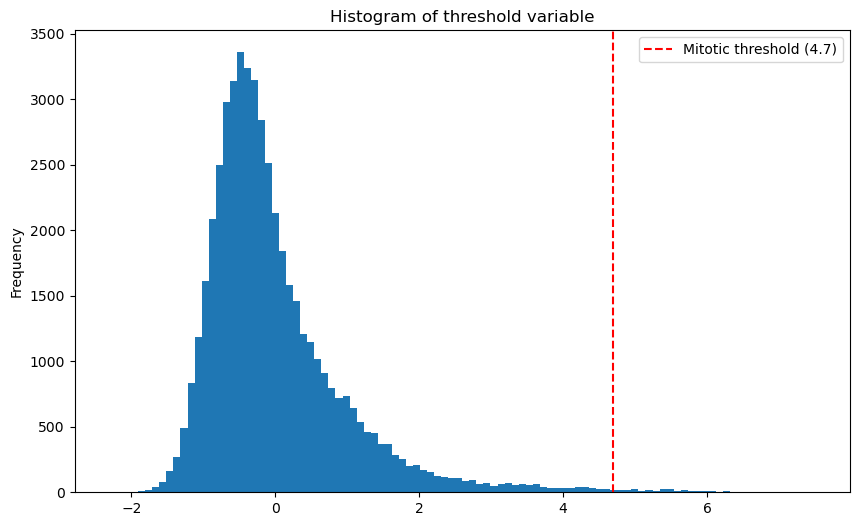

Number of mitotic cells: 272
Total cells: 50,000
Percent mitotic: 0.54%


In [5]:
MITOTIC_THRESHOLD_VARIABLE = "nucleus_DAPI_median"
MITOTIC_THRESHOLD = 4.7

scaled_mitotic_threshold_variable = StandardScaler().fit_transform(cell_data[[MITOTIC_THRESHOLD_VARIABLE]])

percent_mitotic = plot_mitotic_distribution_hist(
    scaled_mitotic_threshold_variable,
    threshold_value=MITOTIC_THRESHOLD,
)

## Define naive classifier

In [6]:
class NaiveMitoticClassifier(CellClassifier):
    def __init__(self, threshold_variable="nucleus_DAPI_median", mitotic_threshold=4.7):
        self.threshold_variable = threshold_variable
        self.mitotic_threshold = mitotic_threshold
        self.scaler = StandardScaler()

    def classify_cells(self, cell_data, feature_start_idx):
        cell_data = cell_data.copy()

        # Scale the threshold variable column
        cell_data[f"{self.threshold_variable}_scaled"] = self.scaler.fit_transform(
            cell_data[self.threshold_variable].values.reshape(-1, 1)
        )
        scaled_var = f"{self.threshold_variable}_scaled"

        # Classify cells
        classes = np.where(cell_data[scaled_var] > self.mitotic_threshold, 'mitotic', 'interphase')
        cell_data['class'] = classes

        # Compute confidence
        cell_data['distance_from_threshold'] = np.abs(cell_data[scaled_var] - self.mitotic_threshold)
        confidence_values = []
        for class_type in ['mitotic', 'interphase']:
            class_mask = cell_data['class'] == class_type
            if not any(class_mask):
                continue
            distances = cell_data.loc[class_mask, 'distance_from_threshold']
            if len(distances) <= 1 or distances.min() == distances.max():
                class_confidences = np.ones(len(distances))
            else:
                class_confidences = (distances - distances.min()) / (distances.max() - distances.min())
            confidence_values.append(pd.Series(class_confidences, index=distances.index))
        confidences = pd.concat(confidence_values).to_numpy()

        return classes, confidences

In [7]:
# Instantiate the classifier
classifier = NaiveMitoticClassifier()

# Predict classes and confidences
classes, confidences = classifier.classify_cells(cell_data, 17)

# Add classes and confidences to the cell data
classified_cell_data = cell_data
classified_cell_data['class'] = classes
classified_cell_data['confidence'] = confidences
classified_cell_data = add_filenames(classified_cell_data, ROOT_FP)
classified_cell_data

,plate,well,tile,cell_0,i_0,j_0,site,cell_1,i_1,j_1,...,cell_second_neighbor_distance,cell_angle_between_neighbors,cytoplasm_number_neighbors_1,cytoplasm_percent_touching_1,cytoplasm_first_neighbor_distance,cytoplasm_second_neighbor_distance,cytoplasm_angle_between_neighbors,class,confidence,image_path
0,1,A1,1045,429,1478.403947,1481.714474,243,254,100.607843,670.117647,...,54.812638,164.492958,0.0,0.000000,48.482563,55.773102,160.427741,interphase,0.071531,analysis_root/preprocess/images/phenotype/P-1_...
1,1,A1,401,485,1477.766431,1478.877654,101,294,100.089552,669.910448,...,62.882030,106.480590,1.0,0.028818,40.760186,57.586665,116.482954,interphase,0.297538,analysis_root/preprocess/images/phenotype/P-1_...
2,1,A1,1502,501,1480.628283,1477.384343,354,277,100.674419,99.806202,...,74.421862,151.065981,0.0,0.000000,52.674577,70.256562,166.276907,interphase,0.674813,analysis_root/preprocess/images/phenotype/P-1_...
3,1,A1,595,475,1480.676399,1482.874696,154,221,100.764706,670.764706,...,52.151249,171.453465,2.0,0.040404,39.327858,47.072292,154.575718,interphase,0.641099,analysis_root/preprocess/images/phenotype/P-1_...
4,1,A1,1479,601,1477.695030,1481.850904,365,346,99.764045,671.494382,...,61.333366,138.748450,0.0,0.000000,62.644570,63.731803,133.933684,interphase,0.006422,analysis_root/preprocess/images/phenotype/P-1_...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,1,A1,1125,453,1480.076923,1755.965545,278,220,100.432099,168.814815,...,57.920520,168.921134,1.0,0.015625,52.825726,62.730908,168.160355,interphase,0.626818,analysis_root/preprocess/images/phenotype/P-1_...
49996,1,A1,1408,731,1753.173077,1440.839744,338,2338,739.098765,92.271605,...,75.970693,59.774914,0.0,0.000000,65.328179,79.941206,91.112332,interphase,0.720488,analysis_root/preprocess/images/phenotype/P-1_...
49997,1,A1,525,334,1227.967429,1592.447678,120,1347,608.121212,697.919192,...,59.403882,169.852034,0.0,0.000000,49.825625,59.247234,172.702028,interphase,0.725264,analysis_root/preprocess/images/phenotype/P-1_...
49998,1,A1,56,503,1600.628225,1728.227618,19,350,130.087379,160.582524,...,69.059469,44.366065,0.0,0.000000,62.061594,64.824308,55.486461,interphase,0.846307,analysis_root/preprocess/images/phenotype/P-1_...


## Create figure to evaluate DAPI cutoff

In [ ]:
# Use final thresholding to split cells
mitotic_df = classified_cell_data[classified_cell_data["class"] == "mitotic"]
interphase_df = classified_cell_data[classified_cell_data["class"] == "interphase"]
print(
    f"Subsetting {len(mitotic_df)} mitotic cells and {len(interphase_df)} interphase cells"
)

# Create figure to evaluate DAPI cutoff

titles = [
    "Randomly Selected Interphase Cells - DAPI",
    "Randomly Selected Mitotic Cells - DAPI",
    "Lowest Confidence Interphase Cells - DAPI",
    "Lowest Confidence Mitotic Cells - DAPI",
    "Highest Confidence Interphase Cells - DAPI",
    "Highest Confidence Mitotic Cells - DAPI",
]

# Get channels from config
CHANNELS = config["phenotype"]["channel_names"]
montages = [
    create_cell_montage(
        cell_data=interphase_df,
        channels=CHANNELS,
        selection_params={
            "method": "random",
        },
    )["DAPI"],
    create_cell_montage(
        cell_data=mitotic_df,
        channels=CHANNELS,
        selection_params={
            "method": "random",
        },
    )["DAPI"],
    create_cell_montage(
        cell_data=interphase_df,
        channels=CHANNELS,
        selection_params={
            "method": "sorted",
            "sort_by": "confidence",
            "ascending": True,
        },
    )["DAPI"],
    create_cell_montage(
        cell_data=mitotic_df,
        channels=CHANNELS,
        selection_params={
            "method": "sorted",
            "sort_by": "confidence",
            "ascending": True,
        },
    )["DAPI"],
    create_cell_montage(
        cell_data=interphase_df,
        channels=CHANNELS,
        selection_params={
            "method": "sorted",
            "sort_by": "confidence",
            "ascending": False,
        },
    )["DAPI"],
    create_cell_montage(
        cell_data=mitotic_df,
        channels=CHANNELS,
        selection_params={
            "method": "sorted",
            "sort_by": "confidence",
            "ascending": False,
        },
    )["DAPI"],
]

# Initialize figure and subplots
fig, axes = plt.subplots(2, 3, figsize=(10, 4))

# Display each montage
for ax, title, montage in zip(axes.flat, titles, montages):
    ax.imshow(montage, cmap="gray")
    ax.set_title(title, fontsize=14)
    ax.axis("off")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

## Save classifier

In [8]:
classifier.save("config/naive_mitotic_classifier.pkl")